# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.89KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

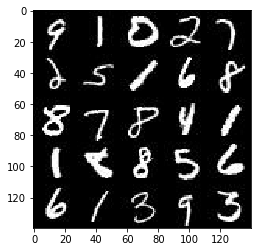

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

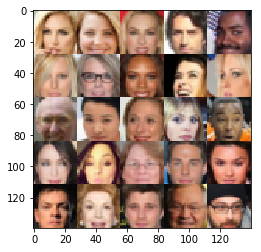

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0


/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [99]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/julian/miniconda3/envs/tflearn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', '

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [102]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
     
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [124]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    with tf.variable_scope("generator", reuse = not is_train):
        
        
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides = 2, padding = "same")
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4 * alpha, x4)
        
        x5 = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides = 1, padding = 'same')
        logits = tf.image.resize_images(x5, [28,28])
        out = tf.tanh(logits)
        
        return out
 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [130]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_output = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [142]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [i for i in t_vars if i.name.startswith('discriminator')]
    g_vars = [i for i in t_vars if i.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [143]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [144]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples = []
    losses  = []
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_optimizer, g_traing_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    g_output = generator(input_z, image_channels, is_train=False)
    
    
    iteration = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                iteration += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_optimizer, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_traing_optimizer, feed_dict={input_z: batch_z})
                
                
                if iteration % 150 == 0:
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)
                    
                if iteration % 20 == 0:
                    d_loss_train = sess.run(d_loss, {input_z : batch_z, input_real : batch_images})
                    g_loss_train = g_loss.eval({input_z : batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                    
                    losses.append((d_loss_train, g_loss_train))
                    
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1666... Generator Loss: 6.9849
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 0.4493... Generator Loss: 2.6150
Epoch 1/2... Discriminator Loss: 0.2532... Generator Loss: 2.3127
Epoch 1/2... Discriminator Loss: 0.3292... Generator Loss: 1.8284
Epoch 1/2... Discriminator Loss: 0.3099... Generator Loss: 1.8818
Epoch 1/2... Discriminator Loss: 0.2208... Generator Loss: 2.2767


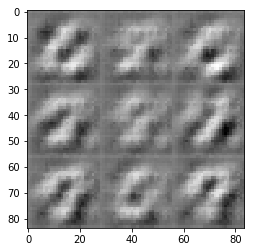

Epoch 1/2... Discriminator Loss: 0.1214... Generator Loss: 2.8543
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 0.0494... Generator Loss: 4.3852
Epoch 1/2... Discriminator Loss: 0.0355... Generator Loss: 4.6906
Epoch 1/2... Discriminator Loss: 2.2327... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 0.2184... Generator Loss: 2.6042
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.4138


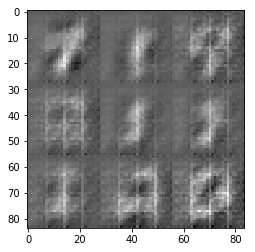

Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 2.5353
Epoch 1/2... Discriminator Loss: 0.3640... Generator Loss: 2.6874
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 2.6195
Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 3.1856
Epoch 1/2... Discriminator Loss: 0.3880... Generator Loss: 1.5823
Epoch 1/2... Discriminator Loss: 0.2758... Generator Loss: 2.4824
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 1.3177
Epoch 1/2... Discriminator Loss: 0.3878... Generator Loss: 2.0196


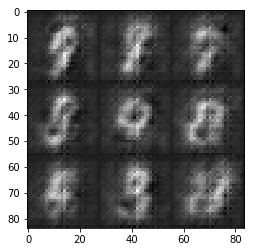

Epoch 1/2... Discriminator Loss: 0.2988... Generator Loss: 2.2535
Epoch 1/2... Discriminator Loss: 0.7477... Generator Loss: 0.8941
Epoch 1/2... Discriminator Loss: 0.3816... Generator Loss: 3.2199
Epoch 1/2... Discriminator Loss: 0.4045... Generator Loss: 2.9378
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 1.4660
Epoch 1/2... Discriminator Loss: 0.5146... Generator Loss: 3.8264
Epoch 1/2... Discriminator Loss: 0.2411... Generator Loss: 2.4031


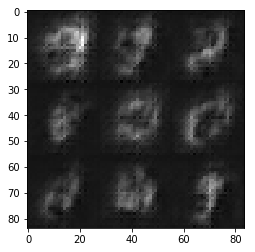

Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 1.1054
Epoch 1/2... Discriminator Loss: 1.6060... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 0.3001... Generator Loss: 2.0660
Epoch 1/2... Discriminator Loss: 0.7843... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 1.4544
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 2.3033
Epoch 1/2... Discriminator Loss: 0.5275... Generator Loss: 1.1715
Epoch 1/2... Discriminator Loss: 0.2337... Generator Loss: 2.5036


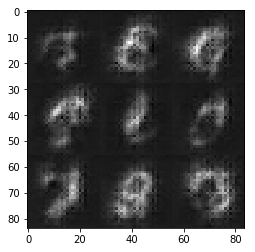

Epoch 1/2... Discriminator Loss: 0.2499... Generator Loss: 2.1015
Epoch 1/2... Discriminator Loss: 0.7275... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 0.4937... Generator Loss: 1.3014
Epoch 1/2... Discriminator Loss: 0.2390... Generator Loss: 2.2302
Epoch 1/2... Discriminator Loss: 0.4243... Generator Loss: 1.3284
Epoch 1/2... Discriminator Loss: 0.2364... Generator Loss: 2.0699
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 0.8088


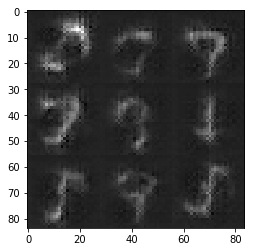

Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 1.4221
Epoch 1/2... Discriminator Loss: 0.0990... Generator Loss: 2.9974
Epoch 2/2... Discriminator Loss: 0.3773... Generator Loss: 1.4706
Epoch 2/2... Discriminator Loss: 1.4653... Generator Loss: 0.4815
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 1.3187
Epoch 2/2... Discriminator Loss: 0.2845... Generator Loss: 2.2373
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 0.3238... Generator Loss: 2.2969


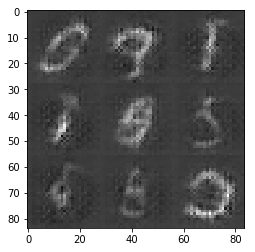

Epoch 2/2... Discriminator Loss: 0.1179... Generator Loss: 3.1513
Epoch 2/2... Discriminator Loss: 0.1798... Generator Loss: 3.7697
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 1.4113
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.6106
Epoch 2/2... Discriminator Loss: 0.2485... Generator Loss: 2.2801
Epoch 2/2... Discriminator Loss: 0.1297... Generator Loss: 3.1546
Epoch 2/2... Discriminator Loss: 0.2729... Generator Loss: 2.1009


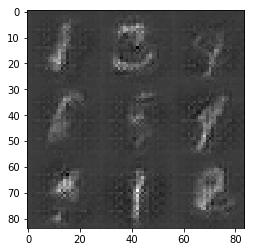

Epoch 2/2... Discriminator Loss: 0.1450... Generator Loss: 2.5559
Epoch 2/2... Discriminator Loss: 0.1135... Generator Loss: 3.1823
Epoch 2/2... Discriminator Loss: 0.5216... Generator Loss: 1.4737
Epoch 2/2... Discriminator Loss: 0.2720... Generator Loss: 1.9858
Epoch 2/2... Discriminator Loss: 0.2904... Generator Loss: 2.2391
Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 4.9790
Epoch 2/2... Discriminator Loss: 0.3226... Generator Loss: 2.9413
Epoch 2/2... Discriminator Loss: 0.4641... Generator Loss: 1.2153


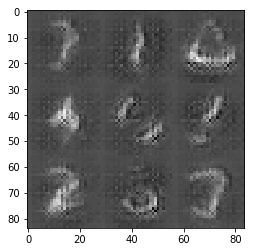

Epoch 2/2... Discriminator Loss: 0.1136... Generator Loss: 3.1157
Epoch 2/2... Discriminator Loss: 0.3963... Generator Loss: 1.4787
Epoch 2/2... Discriminator Loss: 0.1347... Generator Loss: 3.1664
Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 1.9194
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 0.1951... Generator Loss: 2.3611


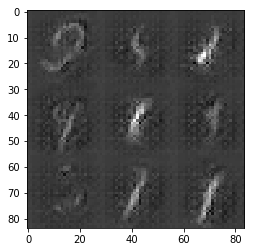

Epoch 2/2... Discriminator Loss: 0.1906... Generator Loss: 2.1935
Epoch 2/2... Discriminator Loss: 1.1543... Generator Loss: 0.5249
Epoch 2/2... Discriminator Loss: 0.4365... Generator Loss: 1.3283
Epoch 2/2... Discriminator Loss: 0.2060... Generator Loss: 2.7302
Epoch 2/2... Discriminator Loss: 0.2614... Generator Loss: 1.8044
Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 1.7812
Epoch 2/2... Discriminator Loss: 0.3375... Generator Loss: 1.6839
Epoch 2/2... Discriminator Loss: 0.1307... Generator Loss: 3.7012


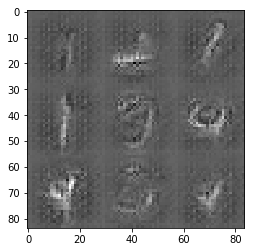

Epoch 2/2... Discriminator Loss: 1.5587... Generator Loss: 3.6047
Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 1.6598
Epoch 2/2... Discriminator Loss: 0.2454... Generator Loss: 2.2392
Epoch 2/2... Discriminator Loss: 0.7116... Generator Loss: 2.6523
Epoch 2/2... Discriminator Loss: 0.2089... Generator Loss: 2.2320
Epoch 2/2... Discriminator Loss: 0.1884... Generator Loss: 2.3038
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.7467


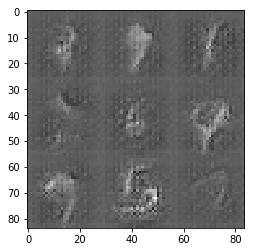

Epoch 2/2... Discriminator Loss: 0.3668... Generator Loss: 1.5977
Epoch 2/2... Discriminator Loss: 0.2268... Generator Loss: 2.8611
Epoch 2/2... Discriminator Loss: 0.2269... Generator Loss: 1.9558
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 1.1802


In [145]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 9.5490
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 3.1502
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 0.1781... Generator Loss: 3.8112
Epoch 1/1... Discriminator Loss: 0.1264... Generator Loss: 2.8623
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.4594


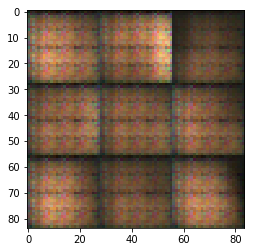

Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.3726
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.8997


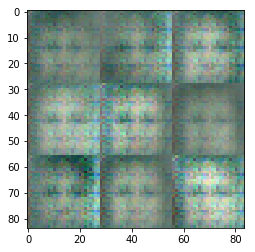

Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 1.9193
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 3.5900


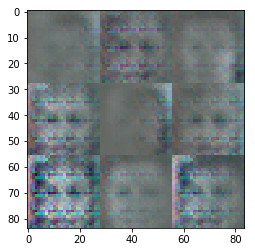

Epoch 1/1... Discriminator Loss: 0.1667... Generator Loss: 4.5173
Epoch 1/1... Discriminator Loss: 0.3073... Generator Loss: 4.7140
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 2.5370
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 3.0189
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 1.7336


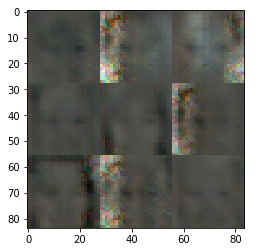

Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 2.2694
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 4.3336
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 3.3565
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 3.5649
Epoch 1/1... Discriminator Loss: 0.4294... Generator Loss: 1.5685


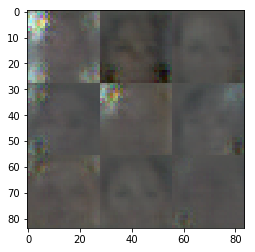

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 2.5816
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.6443
Epoch 1/1... Discriminator Loss: 0.2828... Generator Loss: 2.6846
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.8396
Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 2.9632
Epoch 1/1... Discriminator Loss: 0.2653... Generator Loss: 3.8543
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.0572


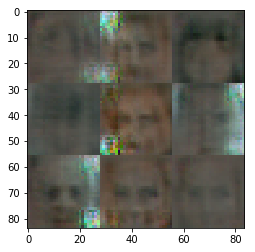

Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 2.0637
Epoch 1/1... Discriminator Loss: 0.2834... Generator Loss: 2.4170
Epoch 1/1... Discriminator Loss: 1.7057... Generator Loss: 1.9676
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 3.2418
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 2.3499
Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 2.9588


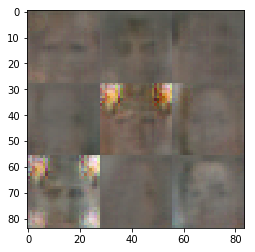

Epoch 1/1... Discriminator Loss: 0.2919... Generator Loss: 3.0005
Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 1.9691
Epoch 1/1... Discriminator Loss: 0.2624... Generator Loss: 3.3377
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 2.2847
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 2.9060
Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 1.8953


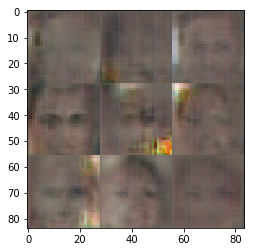

Epoch 1/1... Discriminator Loss: 0.2991... Generator Loss: 2.4126
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 2.5021
Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 2.5152
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 1.6479
Epoch 1/1... Discriminator Loss: 0.3371... Generator Loss: 2.6356
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 2.0732
Epoch 1/1... Discriminator Loss: 3.7125... Generator Loss: 5.5256
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 2.4991


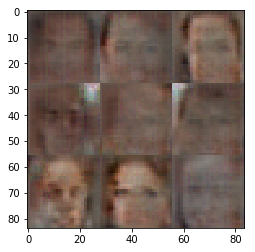

Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 1.6742
Epoch 1/1... Discriminator Loss: 0.2837... Generator Loss: 2.6350
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 1.5564
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 2.9980
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 1.8736


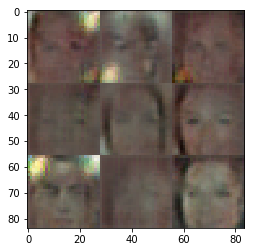

Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 2.9020
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 2.0179
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 2.7561
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 2.4453
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 1.9044
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.0755


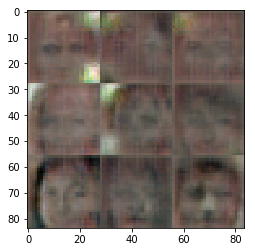

Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 1.8722
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 1.7888
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.2809


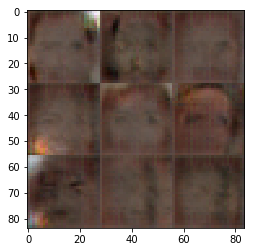

Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 2.0944
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 0.2784... Generator Loss: 2.6272
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 2.4108
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 2.9574
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.5914


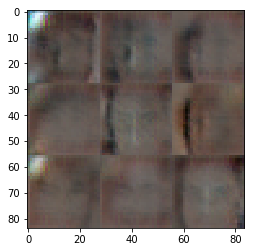

Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 2.0597
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.8268
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 1.7819


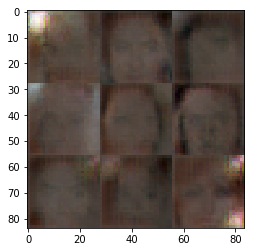

Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 2.0128
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 2.3830
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 2.1084
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 3.3307
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.2773


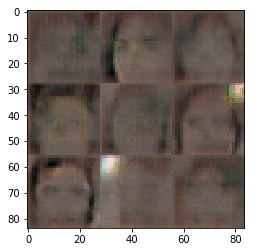

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.7315
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 1.8658
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.5572


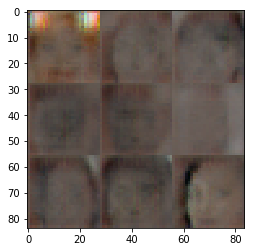

Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.7802
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6138


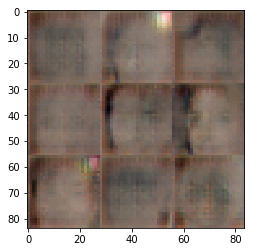

Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.8750
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.0490


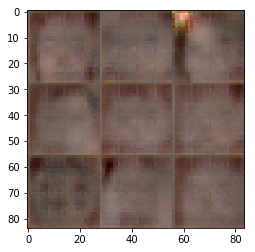

Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.5399
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 1.7309
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6266


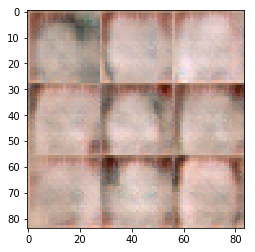

Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.4708
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.7232


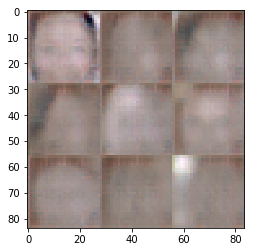

Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.1880
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.0773
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 2.1560
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 0.7954


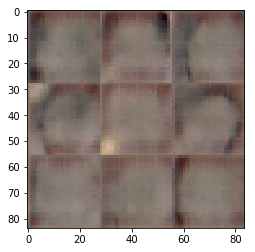

Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 0.6533


In [146]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.